# Summary

----


# Imports

In [1]:
NOTEBOOK_NAME = 'protherm'

In [2]:
%run common_imports.ipynb

2016-04-26 15:58:34.687097


# Extract

In [3]:
ls ../downloads/

abdellah_et_al.tsv.gz  kineticdb.html  ProTherm.dat     small_studies.ods
kineticdb2.html        pfd_all.html    ProTherm.dat.gz
kineticdb_all.html     pfd.html        rosetta_ddg.zip


In [4]:
!mkdir $NOTEBOOK_NAME

mkdir: cannot create directory ‘protherm’: File exists


In [5]:
!gzip -dkf ../downloads/ProTherm.deat.gz $NOTEBOOK_NAME/

gzip: ../downloads/ProTherm.deat.gz: No such file or directory
gzip: protherm/ is a directory -- ignored


# Load ProTherm

In [6]:
# Parse protherm into entry chunks
protherm_filename_full = '../downloads/ProTherm.dat.gz'
with gzip.open(protherm_filename_full, 'rt', encoding='cp437') as ifh:
    file_data_chunks = [x.strip() for x in ifh.read().split('//')]

In [7]:
# Convert entry chunks into rows and combine
COLUMNS = []

def get_unique_columns(columns):
    seen = set()
    for c in columns:
        i, c_orig = 0, i
        while c in seen:
            i += 1
            c = c_orig + '_{}'.format(i)
        seen.add(c)
        yield c

def convert_chunks_to_rows(file_data_chunks):
    global COLUMNS
    for i in range(len(file_data_chunks)):
        # Don't return an empty dict for an empty chunk
        if not file_data_chunks[i].strip(' \n'):
            continue
        column = None
        column_old = None
        columns = []
        row = defaultdict(list)
        for line in file_data_chunks[i].split('\n'):
            if line.startswith('***'):
                continue
            column_old = column if column else column_old
            column = line.split(' ')[0]
            column_version = 1
            while column in columns:
                column_version += 1
                column = line.split(' ')[0] + '_{}'.format(column_version)
            value = ' '.join(line.split(' ')[1:]).strip(' \n')
            if not column:
                if not column_old or not value:
                    error_message = (
                        'i: {}, line: {}, column: {}, column_old: {}, value: {}'.format(
                            i, line, column, column_old, value))
                    raise Exception(error_message)
                row[column_old][-1] += ' ' + value
            else:
                row[column].append(value)
                columns.append(column)
        if len(columns) > len(COLUMNS):
            COLUMNS = columns
        yield {key: ','.join(values) for (key, values) in row.items()}

rows = list(convert_chunks_to_rows(file_data_chunks))
df = pd.DataFrame(rows, columns=COLUMNS)

In [8]:
COLUMNS

['NO.',
 'PROTEIN',
 'SOURCE',
 'LENGTH',
 'MOL-WEIGHT',
 'PIR_ID',
 'SWISSPROT_ID',
 'E.C.NUMBER',
 'PMD.NO',
 'PDB_wild',
 'PDB_mutant',
 'MUTATION',
 'MUTATED_CHAIN',
 'NO_MOLECULE',
 'SEC.STR.',
 'ASA',
 'T',
 'pH',
 'BUFFER_NAME',
 'BUFFER_CONC',
 'ION_NAME_1',
 'ION_CONC_1',
 'ADDITIVES',
 'PROTEIN_CONC',
 'MEASURE',
 'METHOD',
 'dG_H2O',
 'ddG_H2O',
 'dG',
 'ddG',
 'Tm',
 'dTm',
 'dHvH',
 'dHcal',
 'm',
 'Cm',
 'dCp',
 'STATE',
 'REVERSIBILITY',
 'ACTIVITY',
 'ACTIVITY_Km',
 'ACTIVITY_Kcat',
 'ACTIVITY_Kd',
 'REVERSIBILITY_2',
 'ACTIVITY_2',
 'ACTIVITY_Km_2',
 'ACTIVITY_Kcat_2',
 'ACTIVITY_Kd_2',
 'KEY_WORDS',
 'REFERENCE',
 'AUTHOR',
 'REMARKS',
 'RELATED_ENTRIES']

In [9]:
print(df.shape)

(25829, 53)


In [10]:
# Replace empty strings with NaNs and remove all-empty rows
df[df == ''] = np.nan
df = df.dropna(subset=['NO.'])
print(df.shape)

(25823, 53)


In [11]:
df = df[~((df['PDB_wild'] == '1OTR') & (df['MUTATION'].str.startswith('A 33')))]
print(df.shape)

(25703, 53)


In [12]:
display(df.head(2))

,NO.,PROTEIN,SOURCE,LENGTH,MOL-WEIGHT,PIR_ID,SWISSPROT_ID,E.C.NUMBER,PMD.NO,PDB_wild,PDB_mutant,MUTATION,MUTATED_CHAIN,NO_MOLECULE,SEC.STR.,ASA,T,pH,BUFFER_NAME,BUFFER_CONC,ION_NAME_1,ION_CONC_1,ADDITIVES,PROTEIN_CONC,MEASURE,METHOD,dG_H2O,ddG_H2O,dG,ddG,Tm,dTm,dHvH,dHcal,m,Cm,dCp,STATE,REVERSIBILITY,ACTIVITY,ACTIVITY_Km,ACTIVITY_Kcat,ACTIVITY_Kd,REVERSIBILITY_2,ACTIVITY_2,ACTIVITY_Km_2,ACTIVITY_Kcat_2,ACTIVITY_Kd_2,KEY_WORDS,REFERENCE,AUTHOR,REMARKS,RELATED_ENTRIES
0,1,Phospholipase A2,Bovine,130,14536.12,PSBOA,PA21_BOVIN (P00593),EC 3.4.23.4,A930651,1BP2,NaN,wild,-,1,NaN,NaN,30.0,8.0,borate,10 mM,NaN,NaN,"EDTA (0.1 mM),",5 mM,CD,GdnHCl,9.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.47,6.90,NaN,NaN,Unknown,NaN,1.4,675,NaN,NaN,NaN,NaN,NaN,NaN,catalytic triad; PLA2; conformational stabilit...,"J AM CHEM SOC 115, 8523-8526 (1993) PMID:",Li Y. & Tsai M.-D.,"additive : EDTA(0.1 mM),","2,3,4,"
1,2,Phospholipase A2,Bovine,130,14513.08,PSBOA,PA21_BOVIN (P00593),EC 3.4.23.4,A930651,1BP2,NaN,H 48 N,-,1,Helix,17.1,30.0,8.00,borate,10 mM,NaN,NaN,"EDTA (0.1 mM),",5 mM,CD,GdnHCl,6.50,-3.00,NaN,NaN,NaN,NaN,NaN,NaN,1.20,5.40,NaN,NaN,Unknown,NaN,2.6,0.04,NaN,NaN,NaN,NaN,NaN,NaN,catalytic triad; PLA2; conformational stabilit...,"J AM CHEM SOC 115, 8523-8526 (1993) PMID:",Li Y. & Tsai M.-D.,"additive : EDTA(0.1 mM),","1,3,4,"


In [13]:
def parse_swissprot_id(swissprot_id):
    """
    """
    uniprot_name_conversion = {
        'MK10_HUMAN': 'BRCA1_HUMAN',  # BRCA1
    }
    uniprot_id_conversion = {
        'P69542': 'P69543',
        'P53779': 'P38398',  # BRCA1
    }
    #
    if pd.isnull(swissprot_id):
        return np.nan, np.nan
    row = list(filter(lambda x: x, map(lambda x: x.strip(' ()'), swissprot_id.split())))
    if len(row) == 0:
        uniprot_name, uniprot_id = None, None
    elif len(row) == 1:
        uniprot_name, uniprot_id = row[0], None
    elif len(row) == 2:
        uniprot_name, uniprot_id = row
    else:
        raise Exception('Unknown row: {}, swissprot_id: {}'.format(row, swissprot_id))
    uniprot_name = uniprot_name_conversion.get(uniprot_name, uniprot_name)
    uniprot_id = uniprot_id_conversion.get(uniprot_id, uniprot_id)
    return uniprot_name, uniprot_id

df['uniprot_name_protherm'], df['uniprot_id_protherm'] = zip(*df['SWISSPROT_ID'].apply(parse_swissprot_id))

In [14]:
df['protein_name'] = df['PROTEIN']

In [15]:
pdb_id_conversion = {
    'érf5v': '3f5v',
    '1bgl': '4v40',
}
df['pdb_id'] = df['PDB_wild'].apply(lambda x: pdb_id_conversion.get(x, x)).str.lower()

In [16]:
df['pdb_chain'] = df['MUTATED_CHAIN']

In [17]:
df['pdb_mutation'] = df['MUTATION'].str.upper()

In [18]:
import protherm
reload(protherm)
protherm.SIFTS_CACHE_DIR = '/tmp/strokach'
os.makedirs(protherm.SIFTS_CACHE_DIR, exist_ok=True)

df['uniprot_id'], df['uniprot_mutation'], df['pdb_mutation_sifts'] = zip(*
    df[['pdb_id', 'pdb_mutation', 'uniprot_id_protherm']].apply(protherm.get_uniprot_id_mutation_protherm, axis=1)
)

SIFTS failed to match residue (1av1, W, 8, P02647): {'pdb_id': '1av1', 'uniprot_id_protherm': 'P02647', 'pdb_mutation': 'W 8 F, W 50 F, W 72 F, W 108 F'}
SIFTS failed to match residue (1av1, W, 3, P02647): {'pdb_id': '1av1', 'uniprot_id_protherm': 'P02647', 'pdb_mutation': 'W 3 F, W 50 F, W 72 F, W 108 F'}
SIFTS failed to match residue (1av1, W, 3, P02647): {'pdb_id': '1av1', 'uniprot_id_protherm': 'P02647', 'pdb_mutation': 'W 3 F, W 8 F, W 72 F, W 108 F'}
SIFTS failed to match residue (1av1, W, 3, P02647): {'pdb_id': '1av1', 'uniprot_id_protherm': 'P02647', 'pdb_mutation': 'W 3 F, W 8 F, W 50 F, W 108 F'}
SIFTS failed to match residue (1av1, W, 3, P02647): {'pdb_id': '1av1', 'uniprot_id_protherm': 'P02647', 'pdb_mutation': 'W 3 F, W 8 F, W 50 F, W 72 F'}
SIFTS failed to match residue (1ttg, Y, 869, P02751): {'pdb_id': '1ttg', 'uniprot_id_protherm': 'P02751', 'pdb_mutation': 'Y 68 F (PDB: Y 869 F; PIR: Y 869 F)'}
SIFTS has no UniProt annotation for this protein: {'pdb_id': '2imm', 'uni


SIFTS has no UniProt annotation for this protein: {'pdb_id': '2imm', 'uniprot_id_protherm': 'P01868', 'pdb_mutation': 'N 90 Q'}
SIFTS has no UniProt annotation for this protein: {'pdb_id': '2imm', 'uniprot_id_protherm': 'P01868', 'pdb_mutation': 'F 32 Y'}
SIFTS has no UniProt annotation for this protein: {'pdb_id': '2imm', 'uniprot_id_protherm': 'P01868', 'pdb_mutation': 'L 106 I'}
SIFTS has no UniProt annotation for this protein: {'pdb_id': '2imm', 'uniprot_id_protherm': 'P01868', 'pdb_mutation': 'T 63 S'}
SIFTS has no UniProt annotation for this protein: {'pdb_id': '2imm', 'uniprot_id_protherm': 'P01868', 'pdb_mutation': 'M 21 I'}
SIFTS has no UniProt annotation for this protein: {'pdb_id': '2imm', 'uniprot_id_protherm': 'P01868', 'pdb_mutation': 'K 24 R'}
SIFTS has no UniProt annotation for this protein: {'pdb_id': '2imm', 'uniprot_id_protherm': 'P01868', 'pdb_mutation': 'M 21 L'}
SIFTS has no UniProt annotation for this protein: {'pdb_id': '2imm', 'uniprot_id_protherm': 'P01868', 


SIFTS failed to match residue (1ten, L, 92, P24821): {'pdb_id': '1ten', 'uniprot_id_protherm': 'P24821', 'pdb_mutation': 'L 92 A'}
SIFTS failed to match residue (1c9o, L, 67, P41016): {'pdb_id': '1c9o', 'uniprot_id_protherm': 'P41016', 'pdb_mutation': 'L 67 AL'}
SIFTS failed to match residue (1c5g, R, 30, P05121): {'pdb_id': '1c5g', 'uniprot_id_protherm': 'P05121', 'pdb_mutation': 'R 30 E'}
SIFTS failed to match residue (1c5g, R, 30, P05121): {'pdb_id': '1c5g', 'uniprot_id_protherm': 'P05121', 'pdb_mutation': 'R 30 E, E 350 R'}
SIFTS failed to match residue (1rro, E, 108, P02625): {'pdb_id': '1rro', 'uniprot_id_protherm': 'P02625', 'pdb_mutation': 'E 108 ES'}


SIFTS failed to match residue (1k42, E, 11, P96988): {'pdb_id': '1k42', 'uniprot_id_protherm': 'P96988', 'pdb_mutation': 'E 11 A'}
SIFTS failed to match residue (1k42, E, 11, P96988): {'pdb_id': '1k42', 'uniprot_id_protherm': 'P96988', 'pdb_mutation': 'E 11 A'}
SIFTS failed to match residue (1k42, D, 160, P96988): {'pdb_id': '1k42', 'uniprot_id_protherm': 'P96988', 'pdb_mutation': 'D 160 A'}
SIFTS failed to match residue (1k42, D, 160, P96988): {'pdb_id': '1k42', 'uniprot_id_protherm': 'P96988', 'pdb_mutation': 'D 160 A'}
SIFTS failed to match residue (1k42, E, 11, P96988): {'pdb_id': '1k42', 'uniprot_id_protherm': 'P96988', 'pdb_mutation': 'E 11 A, D 160 A'}
SIFTS failed to match residue (1k42, E, 11, P96988): {'pdb_id': '1k42', 'uniprot_id_protherm': 'P96988', 'pdb_mutation': 'E 11 A, D 160 A'}
SIFTS failed to match residue (1k42, E, 23, P96988): {'pdb_id': '1k42', 'uniprot_id_protherm': 'P96988', 'pdb_mutation': 'E 23 A'}
SIFTS failed to match residue (1k42, E, 23, P96988): {'pdb_i


SIFTS failed to match residue (2zta, V, 2, P03069): {'pdb_id': '2zta', 'uniprot_id_protherm': 'P03069', 'pdb_mutation': 'RV 1 V, Y 17 W'}
SIFTS failed to match residue (1arr, M, 31, P03050): {'pdb_id': '1arr', 'uniprot_id_protherm': 'P03050', 'pdb_mutation': 'M 31 A'}
SIFTS failed to match residue (1arr, Y, 36, P03050): {'pdb_id': '1arr', 'uniprot_id_protherm': 'P03050', 'pdb_mutation': 'Y 36 A'}
SIFTS failed to match residue (1arr, L, 40, P03050): {'pdb_id': '1arr', 'uniprot_id_protherm': 'P03050', 'pdb_mutation': 'L 40 A'}
SIFTS failed to match residue (2lzm, R, 137, P00720): {'pdb_id': '2lzm', 'uniprot_id_protherm': 'P00720', 'pdb_mutation': 'E 128 A, V 131 A, N 132 A, K 135 A, S 136 A, R 137 A'}
SIFTS failed to match residue (2lzm, R, 137, P00720): {'pdb_id': '2lzm', 'uniprot_id_protherm': 'P00720', 'pdb_mutation': 'D 127 A, E 128 A, V 131 A, N 132 A, K 135 A, S 136 A, R 137 A'}
SIFTS failed to match residue (2lzm, R, 137, P00720): {'pdb_id': '2lzm', 'uniprot_id_protherm': 'P00720


SIFTS failed to match residue (1uw3, H, 154, P23907): {'pdb_id': '1uw3', 'uniprot_id_protherm': 'P23907', 'pdb_mutation': 'H 154 R, R 171 Q'}
SIFTS failed to match residue (1uw3, H, 154, P23907): {'pdb_id': '1uw3', 'uniprot_id_protherm': 'P23907', 'pdb_mutation': 'H 154 R'}
SIFTS failed to match residue (1mbd, I, 86, P02185): {'pdb_id': '1mbd', 'uniprot_id_protherm': 'P02185', 'pdb_mutation': 'I 28 L, V 66 I, I 75 L, I 86 V, I 101 L, I 111 V, L 135 I'}
SIFTS failed to match residue (1mbd, I, 86, P02185): {'pdb_id': '1mbd', 'uniprot_id_protherm': 'P02185', 'pdb_mutation': 'I 28 L, V 66 I, I 75 L, I 86 V, I 101 L, I 111 V, L 135 I'}
SIFTS failed to match residue (1mbd, I, 86, P02185): {'pdb_id': '1mbd', 'uniprot_id_protherm': 'P02185', 'pdb_mutation': 'I 28 L, V 66 I, I 75 L, I 86 V, I 101 L, I 111 V, L 135 I'}
SIFTS failed to match residue (1ubq, K, 72, P62988): {'pdb_id': '1ubq', 'uniprot_id_protherm': 'P62988', 'pdb_mutation': 'K 72 E'}
SIFTS failed to match residue (1ubq, K, 72, P0C


Not enough info: {'pdb_id': nan, 'uniprot_id_protherm': nan, 'pdb_mutation': nan}
SIFTS failed to match residue (1pga, I, 27, P06654): {'pdb_id': '1pga', 'uniprot_id_protherm': 'P06654', 'pdb_mutation': 'A 23 L, I 27 Y, Y 45 W'}
SIFTS failed to match residue (1pga, I, 27, P06654): {'pdb_id': '1pga', 'uniprot_id_protherm': 'P06654', 'pdb_mutation': 'A 23 Q, I 27 W, Y 45 F'}
SIFTS failed to match residue (1pga, I, 27, P06654): {'pdb_id': '1pga', 'uniprot_id_protherm': 'P06654', 'pdb_mutation': 'A 23 K, I 27 K, Y 45 F'}
SIFTS failed to match residue (1pga, I, 27, P06654): {'pdb_id': '1pga', 'uniprot_id_protherm': 'P06654', 'pdb_mutation': 'A 23 T, I 27 Q'}
SIFTS failed to match residue (1pga, I, 27, P06654): {'pdb_id': '1pga', 'uniprot_id_protherm': 'P06654', 'pdb_mutation': 'A 23 P, I 27 L, Y 45 L'}
SIFTS failed to match residue (1pga, I, 27, P06654): {'pdb_id': '1pga', 'uniprot_id_protherm': 'P06654', 'pdb_mutation': 'A 23 Y, I 27 Y, Y 45 T'}
SIFTS failed to match residue (1pga, I, 27,

### Thermodynamic features

In [19]:
thermodynamic_parameters = [
    'dG_H2O', 'dG', 'Tm', 'ddG_H2O', 'ddG', 'dTm', 'dHvH'
]


import re
RANGE_RE = re.compile('(\d+)-(\d+)')


def process_params(value):
    # Skip bad values
    # value = ''.join(row[1:])
    if pd.isnull(value):
        return np.nan
    
    if any(v in value for v in ['<', '>', 'Unknown', 'n.d.', 'NO_MOLECULE', 'dimer']):
        print("Could not convert value '{}' to float because it contains a blacklisted character.".format(value))
        return np.nan
    
    # Clean value
    value = value.replace(',', '').replace('/K', '').rstrip('.').lower()
    
    # Convert to float
    conversion = {
        '': 1,
        'kcal/mol': 1,
        'kcal/mole': 1,
        'cal/mol': 0.001,
        'cal/mole': 0.001,
        'kal/mol': 0.001,
        'kal/mole': 0.001,
        'kj/mol': 0.239001,
        'kj/mole': 0.239001,
    }
    new_value = None
    for suffix, cf in conversion.items():
        try:
            new_value = cf * float(value.strip(suffix))
            break
        except ValueError:
            pass

    match = RANGE_RE.findall(value)
    if len(match) == 1:
        value_min, value_max = [float(x) for x in match[0]]
        if (value_max - value_min) < 4:
            new_value = (value_min + value_max) / 2
            print("Converted '{}' to '{}'...".format(value, new_value))

    # Report errors
    if new_value is None:
        print("Could not convert value '{}' to float! Skipping...".format(value))
        
    return new_value

for column in thermodynamic_parameters:
    print('\n' + column)
    df[column.lower() + '_clean'] = df[column].apply(process_params)


dG_H2O
Could not convert value '< -2.0' to float because it contains a blacklisted character.
Could not convert value '<-3' to float because it contains a blacklisted character.

dG
Could not convert value '10.07 (dimer)' to float because it contains a blacklisted character.
Could not convert value '12.56 (dimer)' to float because it contains a blacklisted character.
Could not convert value '9.97 (dimer)' to float because it contains a blacklisted character.
Could not convert value '12.37 (dimer)' to float because it contains a blacklisted character.

Tm
Could not convert value '53.4 (dimer)' to float because it contains a blacklisted character.
Could not convert value '67.3 (dimer)' to float because it contains a blacklisted character.
Could not convert value '< 10.0' to float because it contains a blacklisted character.
Could not convert value '>80' to float because it contains a blacklisted character.
Converted '52-54' to '53.0'...

ddG_H2O
Could not convert value '< -7.5' to float

In [20]:
df['ddg_exp'] = df[['ddg_h2o_clean', 'ddg_clean']].apply(lambda x: x[0] if pd.notnull(x[0]) else x[1], axis=1)

In [21]:
column_names = [
    'errors', 'protherm_no', 'pdb_id', 'protein_name', 'uniprot_name', 'uniprot_id',
    'mutated_pdb_chain', 'mutation', 'mutation_uniprot'
] + thermodynamic_parameters

missing_columns = [c for c in column_names if c not in df.columns]
print(missing_columns)

['errors', 'protherm_no', 'uniprot_name', 'mutated_pdb_chain', 'mutation', 'mutation_uniprot']


# Statistics

In [22]:
display(df.head())
print(df.shape[0])

,NO.,PROTEIN,SOURCE,LENGTH,MOL-WEIGHT,PIR_ID,SWISSPROT_ID,E.C.NUMBER,PMD.NO,PDB_wild,PDB_mutant,MUTATION,MUTATED_CHAIN,NO_MOLECULE,SEC.STR.,ASA,T,pH,BUFFER_NAME,BUFFER_CONC,ION_NAME_1,ION_CONC_1,ADDITIVES,PROTEIN_CONC,MEASURE,METHOD,dG_H2O,ddG_H2O,dG,ddG,Tm,dTm,dHvH,dHcal,m,Cm,dCp,STATE,REVERSIBILITY,ACTIVITY,ACTIVITY_Km,ACTIVITY_Kcat,ACTIVITY_Kd,REVERSIBILITY_2,ACTIVITY_2,ACTIVITY_Km_2,ACTIVITY_Kcat_2,ACTIVITY_Kd_2,KEY_WORDS,REFERENCE,AUTHOR,REMARKS,RELATED_ENTRIES,uniprot_name_protherm,uniprot_id_protherm,protein_name,pdb_id,pdb_chain,pdb_mutation,uniprot_id,uniprot_mutation,pdb_mutation_sifts,dg_h2o_clean,dg_clean,tm_clean,ddg_h2o_clean,ddg_clean,dtm_clean,dhvh_clean,ddg_exp
0,1,Phospholipase A2,Bovine,130,14536.12,PSBOA,PA21_BOVIN (P00593),EC 3.4.23.4,A930651,1BP2,NaN,wild,-,1,NaN,NaN,30.0,8.0,borate,10 mM,NaN,NaN,"EDTA (0.1 mM),",5 mM,CD,GdnHCl,9.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.47,6.90,NaN,NaN,Unknown,NaN,1.4,675,NaN,NaN,NaN,NaN,NaN,NaN,catalytic triad; PLA2; conformational stabilit...,"J AM CHEM SOC 115, 8523-8526 (1993) PMID:",Li Y. & Tsai M.-D.,"additive : EDTA(0.1 mM),","2,3,4,",PA21_BOVIN,P00593,Phospholipase A2,1bp2,-,WILD,P00593,WILD,NaN,9.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Phospholipase A2,Bovine,130,14513.08,PSBOA,PA21_BOVIN (P00593),EC 3.4.23.4,A930651,1BP2,NaN,H 48 N,-,1,Helix,17.1,30.0,8.00,borate,10 mM,NaN,NaN,"EDTA (0.1 mM),",5 mM,CD,GdnHCl,6.50,-3.00,NaN,NaN,NaN,NaN,NaN,NaN,1.20,5.40,NaN,NaN,Unknown,NaN,2.6,0.04,NaN,NaN,NaN,NaN,NaN,NaN,catalytic triad; PLA2; conformational stabilit...,"J AM CHEM SOC 115, 8523-8526 (1993) PMID:",Li Y. & Tsai M.-D.,"additive : EDTA(0.1 mM),","1,3,4,",PA21_BOVIN,P00593,Phospholipase A2,1bp2,-,H 48 N,P00593,H70N,H 48 N,6.5,NaN,NaN,-3.0,NaN,NaN,NaN,-3.0
2,3,Phospholipase A2,Bovine,130,14527.11,PSBOA,PA21_BOVIN (P00593),EC 3.4.23.4,A930651,1BP2,NaN,H 48 Q,-,1,Helix,17.1,30.0,8.00,borate,10 mM,NaN,NaN,"EDTA (0.1 mM),",5 mM,CD,GdnHCl,8.90,-0.60,NaN,NaN,NaN,NaN,NaN,NaN,1.34,6.60,NaN,NaN,Unknown,NaN,NaN,undetectable (<0.001),NaN,NaN,NaN,NaN,NaN,NaN,catalytic triad; PLA2; conformational stabilit...,"J AM CHEM SOC 115, 8523-8526 (1993) PMID:",Li Y. & Tsai M.-D.,"additive : EDTA(0.1 mM),","1,2,4,",PA21_BOVIN,P00593,Phospholipase A2,1bp2,-,H 48 Q,P00593,H70Q,H 48 Q,8.9,NaN,NaN,-0.6,NaN,NaN,NaN,-0.6
3,4,Phospholipase A2,Bovine,130,14470.06,PSBOA,PA21_BOVIN (P00593),EC 3.4.23.4,A930651,1BP2,NaN,H 48 A,-,1,Helix,17.1,30.0,8.00,borate,10 mM,NaN,NaN,"EDTA (0.1 mM),",5 mM,CD,GdnHCl,6.40,-3.10,NaN,NaN,NaN,NaN,NaN,NaN,1.02,6.30,NaN,NaN,Unknown,NaN,NaN,undetectable (<0.001),NaN,NaN,NaN,NaN,NaN,NaN,catalytic triad; PLA2; conformational stabilit...,"J AM CHEM SOC 115, 8523-8526 (1993) PMID:",Li Y. & Tsai M.-D.,"additive : EDTA(0.1 mM),","1,2,3,",PA21_BOVIN,P00593,Phospholipase A2,1bp2,-,H 48 A,P00593,H70A,H 48 A,6.4,NaN,NaN,-3.1,NaN,NaN,NaN,-3.1
4,5,Ribonuclease HI,Escherichia coli,155,17597.00,NRECH,RNH_ECOLI (P0A7Y4),EC 3.1.4.8,A920875,2RN2,NaN,wild,-,1,NaN,NaN,NaN,3.00,glycine-HCl,10 mM,NaN,NaN,NaN,NaN,CD,Thermal,NaN,NaN,NaN,NaN,49.8,0.0,98.1,NaN,NaN,NaN,NaN,NaN,yes,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,structural stability; mutagenesis; free energy...,"J BIOL CHEM 267, 22014-22017 (1992) PMID: 1...","Kimura S., Kanaya S. & Nakamura H.",NaN,"6,7,8,9,10,11,12,13,14,15,16,2143,2144,2145,21...",RNH_ECOLI,P0A7Y4,Ribonuclease HI,2rn2,-,WILD,P0A7Y4,WILD,NaN,NaN,NaN,49.8,NaN,NaN,0,98.1,NaN


25703


In [23]:
# Totally failed
df[['uniprot_id', 'uniprot_mutation']].isnull().any(axis=1).sum()

3335

In [24]:
# Amino acid mismatch
df['uniprot_mutation'].apply(lambda x: '?' in x if pd.notnull(x) else np.nan).sum()

122

In [25]:
Counter(df['pdb_chain'])

Counter({nan: 4101,
         'I': 264,
         'X': 23,
         'O': 52,
         '_': 3644,
         '1': 19,
         '-': 12078,
         'A': 5272,
         'B': 236,
         '_NO_MOLECULE     1      1': 1,
         'A, B, B': 1,
         'P': 12})

In [26]:
df.head()

,NO.,PROTEIN,SOURCE,LENGTH,MOL-WEIGHT,PIR_ID,SWISSPROT_ID,E.C.NUMBER,PMD.NO,PDB_wild,PDB_mutant,MUTATION,MUTATED_CHAIN,NO_MOLECULE,SEC.STR.,ASA,T,pH,BUFFER_NAME,BUFFER_CONC,ION_NAME_1,ION_CONC_1,ADDITIVES,PROTEIN_CONC,MEASURE,METHOD,dG_H2O,ddG_H2O,dG,ddG,Tm,dTm,dHvH,dHcal,m,Cm,dCp,STATE,REVERSIBILITY,ACTIVITY,ACTIVITY_Km,ACTIVITY_Kcat,ACTIVITY_Kd,REVERSIBILITY_2,ACTIVITY_2,ACTIVITY_Km_2,ACTIVITY_Kcat_2,ACTIVITY_Kd_2,KEY_WORDS,REFERENCE,AUTHOR,REMARKS,RELATED_ENTRIES,uniprot_name_protherm,uniprot_id_protherm,protein_name,pdb_id,pdb_chain,pdb_mutation,uniprot_id,uniprot_mutation,pdb_mutation_sifts,dg_h2o_clean,dg_clean,tm_clean,ddg_h2o_clean,ddg_clean,dtm_clean,dhvh_clean,ddg_exp
0,1,Phospholipase A2,Bovine,130,14536.12,PSBOA,PA21_BOVIN (P00593),EC 3.4.23.4,A930651,1BP2,NaN,wild,-,1,NaN,NaN,30.0,8.0,borate,10 mM,NaN,NaN,"EDTA (0.1 mM),",5 mM,CD,GdnHCl,9.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.47,6.90,NaN,NaN,Unknown,NaN,1.4,675,NaN,NaN,NaN,NaN,NaN,NaN,catalytic triad; PLA2; conformational stabilit...,"J AM CHEM SOC 115, 8523-8526 (1993) PMID:",Li Y. & Tsai M.-D.,"additive : EDTA(0.1 mM),","2,3,4,",PA21_BOVIN,P00593,Phospholipase A2,1bp2,-,WILD,P00593,WILD,NaN,9.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Phospholipase A2,Bovine,130,14513.08,PSBOA,PA21_BOVIN (P00593),EC 3.4.23.4,A930651,1BP2,NaN,H 48 N,-,1,Helix,17.1,30.0,8.00,borate,10 mM,NaN,NaN,"EDTA (0.1 mM),",5 mM,CD,GdnHCl,6.50,-3.00,NaN,NaN,NaN,NaN,NaN,NaN,1.20,5.40,NaN,NaN,Unknown,NaN,2.6,0.04,NaN,NaN,NaN,NaN,NaN,NaN,catalytic triad; PLA2; conformational stabilit...,"J AM CHEM SOC 115, 8523-8526 (1993) PMID:",Li Y. & Tsai M.-D.,"additive : EDTA(0.1 mM),","1,3,4,",PA21_BOVIN,P00593,Phospholipase A2,1bp2,-,H 48 N,P00593,H70N,H 48 N,6.5,NaN,NaN,-3.0,NaN,NaN,NaN,-3.0
2,3,Phospholipase A2,Bovine,130,14527.11,PSBOA,PA21_BOVIN (P00593),EC 3.4.23.4,A930651,1BP2,NaN,H 48 Q,-,1,Helix,17.1,30.0,8.00,borate,10 mM,NaN,NaN,"EDTA (0.1 mM),",5 mM,CD,GdnHCl,8.90,-0.60,NaN,NaN,NaN,NaN,NaN,NaN,1.34,6.60,NaN,NaN,Unknown,NaN,NaN,undetectable (<0.001),NaN,NaN,NaN,NaN,NaN,NaN,catalytic triad; PLA2; conformational stabilit...,"J AM CHEM SOC 115, 8523-8526 (1993) PMID:",Li Y. & Tsai M.-D.,"additive : EDTA(0.1 mM),","1,2,4,",PA21_BOVIN,P00593,Phospholipase A2,1bp2,-,H 48 Q,P00593,H70Q,H 48 Q,8.9,NaN,NaN,-0.6,NaN,NaN,NaN,-0.6
3,4,Phospholipase A2,Bovine,130,14470.06,PSBOA,PA21_BOVIN (P00593),EC 3.4.23.4,A930651,1BP2,NaN,H 48 A,-,1,Helix,17.1,30.0,8.00,borate,10 mM,NaN,NaN,"EDTA (0.1 mM),",5 mM,CD,GdnHCl,6.40,-3.10,NaN,NaN,NaN,NaN,NaN,NaN,1.02,6.30,NaN,NaN,Unknown,NaN,NaN,undetectable (<0.001),NaN,NaN,NaN,NaN,NaN,NaN,catalytic triad; PLA2; conformational stabilit...,"J AM CHEM SOC 115, 8523-8526 (1993) PMID:",Li Y. & Tsai M.-D.,"additive : EDTA(0.1 mM),","1,2,3,",PA21_BOVIN,P00593,Phospholipase A2,1bp2,-,H 48 A,P00593,H70A,H 48 A,6.4,NaN,NaN,-3.1,NaN,NaN,NaN,-3.1
4,5,Ribonuclease HI,Escherichia coli,155,17597.00,NRECH,RNH_ECOLI (P0A7Y4),EC 3.1.4.8,A920875,2RN2,NaN,wild,-,1,NaN,NaN,NaN,3.00,glycine-HCl,10 mM,NaN,NaN,NaN,NaN,CD,Thermal,NaN,NaN,NaN,NaN,49.8,0.0,98.1,NaN,NaN,NaN,NaN,NaN,yes,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,structural stability; mutagenesis; free energy...,"J BIOL CHEM 267, 22014-22017 (1992) PMID: 1...","Kimura S., Kanaya S. & Nakamura H.",NaN,"6,7,8,9,10,11,12,13,14,15,16,2143,2144,2145,21...",RNH_ECOLI,P0A7Y4,Ribonuclease HI,2rn2,-,WILD,P0A7Y4,WILD,NaN,NaN,NaN,49.8,NaN,NaN,0,98.1,NaN


In [27]:
df[df['pdb_mutation'] != df['pdb_mutation_sifts']][['pdb_mutation', 'pdb_mutation_sifts']].head(10)

,pdb_mutation,pdb_mutation_sifts
0,WILD,NaN
4,WILD,NaN
5,WILD,NaN
16,WILD,NaN
24,WILD,NaN
37,WILD,NaN
97,WILD,NaN
101,WILD,NaN
104,WILD,NaN
106,WILD,NaN


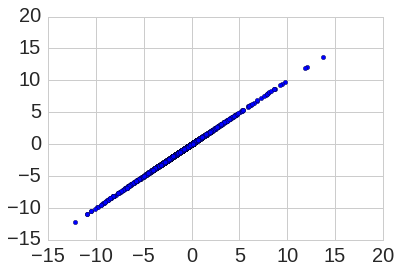

In [28]:
x, y = zip(*df[['ddg_h2o_clean', 'ddg_exp']].dropna().values)
plt.scatter(x, y)

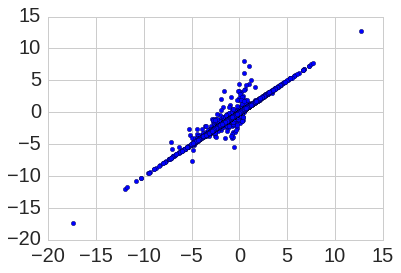

In [29]:
x, y = zip(*df[['ddg_clean', 'ddg_exp']].dropna().values)
plt.scatter(x, y)

# Save

In [30]:
import csv2sql
db = csv2sql.DataFrameToMySQL(
    os.environ['BIODB_CONNECTION_STR'] + '/protein_folding_energy', 
    NOTEBOOK_NAME, 
    os.environ['STG_SERVER_IP'], 
    echo=False
)

In [31]:
df.head()

,NO.,PROTEIN,SOURCE,LENGTH,MOL-WEIGHT,PIR_ID,SWISSPROT_ID,E.C.NUMBER,PMD.NO,PDB_wild,PDB_mutant,MUTATION,MUTATED_CHAIN,NO_MOLECULE,SEC.STR.,ASA,T,pH,BUFFER_NAME,BUFFER_CONC,ION_NAME_1,ION_CONC_1,ADDITIVES,PROTEIN_CONC,MEASURE,METHOD,dG_H2O,ddG_H2O,dG,ddG,Tm,dTm,dHvH,dHcal,m,Cm,dCp,STATE,REVERSIBILITY,ACTIVITY,ACTIVITY_Km,ACTIVITY_Kcat,ACTIVITY_Kd,REVERSIBILITY_2,ACTIVITY_2,ACTIVITY_Km_2,ACTIVITY_Kcat_2,ACTIVITY_Kd_2,KEY_WORDS,REFERENCE,AUTHOR,REMARKS,RELATED_ENTRIES,uniprot_name_protherm,uniprot_id_protherm,protein_name,pdb_id,pdb_chain,pdb_mutation,uniprot_id,uniprot_mutation,pdb_mutation_sifts,dg_h2o_clean,dg_clean,tm_clean,ddg_h2o_clean,ddg_clean,dtm_clean,dhvh_clean,ddg_exp
0,1,Phospholipase A2,Bovine,130,14536.12,PSBOA,PA21_BOVIN (P00593),EC 3.4.23.4,A930651,1BP2,NaN,wild,-,1,NaN,NaN,30.0,8.0,borate,10 mM,NaN,NaN,"EDTA (0.1 mM),",5 mM,CD,GdnHCl,9.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.47,6.90,NaN,NaN,Unknown,NaN,1.4,675,NaN,NaN,NaN,NaN,NaN,NaN,catalytic triad; PLA2; conformational stabilit...,"J AM CHEM SOC 115, 8523-8526 (1993) PMID:",Li Y. & Tsai M.-D.,"additive : EDTA(0.1 mM),","2,3,4,",PA21_BOVIN,P00593,Phospholipase A2,1bp2,-,WILD,P00593,WILD,NaN,9.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Phospholipase A2,Bovine,130,14513.08,PSBOA,PA21_BOVIN (P00593),EC 3.4.23.4,A930651,1BP2,NaN,H 48 N,-,1,Helix,17.1,30.0,8.00,borate,10 mM,NaN,NaN,"EDTA (0.1 mM),",5 mM,CD,GdnHCl,6.50,-3.00,NaN,NaN,NaN,NaN,NaN,NaN,1.20,5.40,NaN,NaN,Unknown,NaN,2.6,0.04,NaN,NaN,NaN,NaN,NaN,NaN,catalytic triad; PLA2; conformational stabilit...,"J AM CHEM SOC 115, 8523-8526 (1993) PMID:",Li Y. & Tsai M.-D.,"additive : EDTA(0.1 mM),","1,3,4,",PA21_BOVIN,P00593,Phospholipase A2,1bp2,-,H 48 N,P00593,H70N,H 48 N,6.5,NaN,NaN,-3.0,NaN,NaN,NaN,-3.0
2,3,Phospholipase A2,Bovine,130,14527.11,PSBOA,PA21_BOVIN (P00593),EC 3.4.23.4,A930651,1BP2,NaN,H 48 Q,-,1,Helix,17.1,30.0,8.00,borate,10 mM,NaN,NaN,"EDTA (0.1 mM),",5 mM,CD,GdnHCl,8.90,-0.60,NaN,NaN,NaN,NaN,NaN,NaN,1.34,6.60,NaN,NaN,Unknown,NaN,NaN,undetectable (<0.001),NaN,NaN,NaN,NaN,NaN,NaN,catalytic triad; PLA2; conformational stabilit...,"J AM CHEM SOC 115, 8523-8526 (1993) PMID:",Li Y. & Tsai M.-D.,"additive : EDTA(0.1 mM),","1,2,4,",PA21_BOVIN,P00593,Phospholipase A2,1bp2,-,H 48 Q,P00593,H70Q,H 48 Q,8.9,NaN,NaN,-0.6,NaN,NaN,NaN,-0.6
3,4,Phospholipase A2,Bovine,130,14470.06,PSBOA,PA21_BOVIN (P00593),EC 3.4.23.4,A930651,1BP2,NaN,H 48 A,-,1,Helix,17.1,30.0,8.00,borate,10 mM,NaN,NaN,"EDTA (0.1 mM),",5 mM,CD,GdnHCl,6.40,-3.10,NaN,NaN,NaN,NaN,NaN,NaN,1.02,6.30,NaN,NaN,Unknown,NaN,NaN,undetectable (<0.001),NaN,NaN,NaN,NaN,NaN,NaN,catalytic triad; PLA2; conformational stabilit...,"J AM CHEM SOC 115, 8523-8526 (1993) PMID:",Li Y. & Tsai M.-D.,"additive : EDTA(0.1 mM),","1,2,3,",PA21_BOVIN,P00593,Phospholipase A2,1bp2,-,H 48 A,P00593,H70A,H 48 A,6.4,NaN,NaN,-3.1,NaN,NaN,NaN,-3.1
4,5,Ribonuclease HI,Escherichia coli,155,17597.00,NRECH,RNH_ECOLI (P0A7Y4),EC 3.1.4.8,A920875,2RN2,NaN,wild,-,1,NaN,NaN,NaN,3.00,glycine-HCl,10 mM,NaN,NaN,NaN,NaN,CD,Thermal,NaN,NaN,NaN,NaN,49.8,0.0,98.1,NaN,NaN,NaN,NaN,NaN,yes,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,structural stability; mutagenesis; free energy...,"J BIOL CHEM 267, 22014-22017 (1992) PMID: 1...","Kimura S., Kanaya S. & Nakamura H.",NaN,"6,7,8,9,10,11,12,13,14,15,16,2143,2144,2145,21...",RNH_ECOLI,P0A7Y4,Ribonuclease HI,2rn2,-,WILD,P0A7Y4,WILD,NaN,NaN,NaN,49.8,NaN,NaN,0,98.1,NaN


In [32]:
db.import_table(
    df, 
    'protherm', [
        [('pdb_id', 'pdb_chain', 'pdb_mutation'), True],
        [('uniprot_id', 'uniprot_mutation'), False],
    ],
)

ERROR:csv2sql.core:The following exception occured:
(_mysql_exceptions.OperationalError) (1812, 'Tablespace is missing for table `protein_folding_energy`.`protherm`.') [SQL: 'DESCRIBE `protherm`']
ERROR:csv2sql.core:Retrying...
ERROR:csv2sql.core:The following exception occured:
(_mysql_exceptions.OperationalError) (1812, 'Tablespace is missing for table `protein_folding_energy`.`protherm`.') [SQL: 'DESCRIBE `protherm`']
ERROR:csv2sql.core:Retrying...
ERROR:csv2sql.core:The following exception occured:
(_mysql_exceptions.OperationalError) (1812, 'Tablespace is missing for table `protein_folding_energy`.`protherm`.') [SQL: 'DESCRIBE `protherm`']
ERROR:csv2sql.core:Retrying...
ERROR:csv2sql.core:The following exception occured:
(_mysql_exceptions.OperationalError) (1812, 'Tablespace is missing for table `protein_folding_energy`.`protherm`.') [SQL: 'DESCRIBE `protherm`']
ERROR:csv2sql.core:Retrying...
ERROR:csv2sql.core:The following exception occured:
(_mysql_exceptions.OperationalError)

OperationalError: (_mysql_exceptions.OperationalError) (1812, 'Tablespace is missing for table `protein_folding_energy`.`protherm`.') [SQL: 'DESCRIBE `protherm`']